In [1]:
import pandas as pd
import numpy as np
from scipy.integrate import dblquad
import time
import gc
import os
import pickle

from math import *
import scipy.stats
from pandas import *
from scipy.integrate import quad
import seaborn as sns
import scipy as s
import warnings
warnings.filterwarnings("ignore")
from mpl_toolkits import mplot3d
import plotly.offline as pyoff
import plotly.graph_objs as go
import plotly.graph_objects as go
from scipy import linalg
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 1000)
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib import rc
from concurrent.futures import ProcessPoolExecutor

DTYPE='float32'

In [2]:
# The below is to load the Fredholm NN classes - Adjust according to your folder architecture/path where the fredholm_nn_models.py has been saved

from google.colab import drive
drive.mount('/content/drive')

FOLDER = "/content/drive/MyDrive/Fredholm_Neural_Networks/Github/Python"

import sys, os, importlib
if FOLDER not in sys.path:
    sys.path.insert(0, FOLDER)

# print("CWD:", os.getcwd())
# print("Folder exists?", os.path.isdir(FOLDER))
# print("Files:", os.listdir(FOLDER)[:10])


from potential_fredholm_nn_models import FredholmNeuralNetwork_semi_linear, PotentialFredholmNeuralNetwork_semi_linear


Mounted at /content/drive


# Functions and definitions used for the the Potential Fredholm Neural Network solution to the semi-linear elliptic PDE.

We consider the two-dimensional linear Poisson equation for $u(x)$:

  \begin{equation}
        \begin{cases}\Delta u(x) = \psi(x), & \text { for } x \in \Omega \\ u(x)= f(x) & \text { for } {x} \in \partial \Omega. \end{cases}
    \end{equation}




The Poisson PDE can be solved using a Fredholm NN, with $M+1$ hidden layers, where the weights and biases of the $M$ hidden layers are used iteratively solve the BIE (\ref{BIE}) on a discretized grid of the boundary, $y_1, \dots, y_N$,
for which the final and output weights $W_{M+1} \in \mathbb{R}^{N \times N}, W_O \in \mathbb{R}^N$ given by:
\begin{equation}
    W_{M+1}= I_{N \times N},
    \,\,\,\,\
    W_{O}= \left(\begin{array}{cccc}
	D \Phi({x}, {y}_1) \delta \sigma_{y}, & D \Phi({x}, {y}_2)\delta \sigma_{y}, & \dots, & {D} \Phi({x}, {y}_N) \delta \sigma_{y}
\end{array}\right)^{\top},
\end{equation}
are used to define the simple operator ${D} \Phi({x}, {y}):= \Big(\frac{\partial \Phi}{\partial n_{y}}({x}, {y})- \frac{\partial \Phi}{\partial n_{y}}({x}^{\star}, {y})\Big)$. The corresponding biases $b_{M+1} \in \mathbb{R}^{N}$ and $b_O \in \mathbb{R}$ are given by:
\begin{equation}
   b_{M+1} = \left(\begin{array}{ccc}
		- \beta({x}^{\star}), \dots, - \beta({x}^{\star})
	\end{array}\right)^{\top}, \,\,\,\   b_O= \frac{1}{2} \beta({x}^{\star}) + \int_{\partial \Omega} \beta(y) \frac{\partial \Phi(x^*, y)}{\partial n_y} d\sigma_y + \int_{\Omega} \Phi({x},{y}) \psi(y) dy,
\end{equation}
where $x^*:= (1, \phi) \in \partial \Omega$ is the unique point on the boundary corresponding to $x:= (r, \phi) \in \Omega$.  


In [3]:
"""
Scalar functions for dblqud of fundamental*source
"""
import numpy as np
from scipy.special import kv
from concurrent.futures import ProcessPoolExecutor

lambda_value = 1.0
tol = 1e-8


def fundamental_fn_scalar(r_2, theta, r_out, theta_out):
    """
    Scalar version of the fundamental function for numerical integration.
    """
    norm = np.sqrt((r_out*np.cos(theta_out) - r_2*np.cos(theta))**2  +  (r_out*np.sin(theta_out) - r_2*np.sin(theta))**2)

    term = (-1/(2*np.pi))*kv(0, np.sqrt(lambda_value)*norm)

    if isnan(term) or isinf(term):
      print(r_2, theta, r_out, theta_out)

    return term


def integrand_scalar_boundary(theta, r_2, r_out, theta_out):
    """
    Integrand for the second integral:
      sqrt(lambda_value) * fundamental_fn_scalar(...) * r_2.
    """
    fundamental = fundamental_fn_scalar(r_2, theta, r_out, theta_out)
    return np.sqrt(lambda_value) * fundamental * r_2


def inner_integration(integrand, r_2, r_out, theta_out):
    """
    Performs the inner integration over theta for a fixed r_2.
    If r_2 is close to r_out (within tol), the singular point theta_out is specified.
    """
    f_theta = lambda theta: integrand(theta, r_2, r_out, theta_out)

    if np.abs(r_2 - r_out) < tol:
        result, error = quad(f_theta, 0, 2 * np.pi, points=[theta_out])
    else:
        result, error = quad(f_theta, 0, 2 * np.pi)

    return result

def full_integration(integrand, r_out, theta_out):
    """
    Performs the full integration by first integrating over theta (inner)
    and then over r_2 (outer).
    """
    f_r2 = lambda r_2: inner_integration(integrand, r_2, r_out, theta_out)
    result, error = quad(f_r2, 0, 1, points=[r_out])
    return result


def integrate_for_out_value_scalar(args):
    """
    Performs the sequential integration for a single (r_out, theta_out) value.
    """
    r_out, theta_out = args
    result = full_integration(integrand_scalar_boundary, r_out, theta_out)
    return result

# # -----------------------------
# # Parallelize over all out_values
# # -----------------------------
def parallel_integrate_meshgrid(r_out_values, theta_out_values):
    """
    Parallel integration for scalar integrals over a meshgrid of (r_out, theta_out)
    values using the sequential two-step integration.

    Args:
        r_out_values (np.array): 1D array of r_out values.
        theta_out_values (np.array): 1D array of theta_out values.

    Returns:
        np.array: 2D array of integral results with shape (len(r_out_values), len(theta_out_values)).
    """
    # Create meshgrid (first axis: r_out, second: theta_out)
    R_out, Theta_out = np.meshgrid(r_out_values, theta_out_values, indexing='ij')

    # Flatten the meshgrid for parallel processing
    out_values = np.column_stack((R_out.ravel(), Theta_out.ravel()))

    # Perform the integrations in parallel
    with ProcessPoolExecutor() as executor:
        results = list(executor.map(integrate_for_out_value_scalar, out_values))

    # Reshape the results to match the original meshgrid shape
    results_array = np.array(results).reshape(R_out.shape)
    return results_array


In [4]:
# Functions for the fundamental solution and the BIE


from scipy.special import kv
lambda_value = 1.0

from scipy.special import kv

def fundamental_fn(out_value, R_2, THETA, r_out):
    """
    Computes:
        (-1/(2*pi)) * K0( sqrt(lambda_value)*norm ) * r_y

    where norm = sqrt( (r_out*cos(theta_out) - r_y*cos(theta_y))^2
                     + (r_out*sin(theta_out) - r_y*sin(theta_y))^2 ).

    Essentially, this is the 2D modified Helmholtz fundamental solution
    multiplied by the polar Jacobian factor r_y (i.e., R_2).

    Parameters
    ----------
    out_value : torch.Tensor or float
        Angular coordinate(s) of the 'field' point, theta_out.
    R_2 : torch.Tensor or float
        Radial coordinate(s) of the 'source' point, r_y.
    THETA : torch.Tensor or float
        Angular coordinate(s) of the 'source' point, theta_y.
    r_out : torch.Tensor or float, optional
        Radial coordinate(s) of the 'field' point, default=1.0.
    lambda_value : float, optional
        The PDE parameter under the square root for the Bessel argument,
        default=1.0.

    Returns
    -------
    torch.Tensor
        The fundamental solution times r_y. If you later integrate over
        r_y and theta_y in polar coordinates, you do NOT need to multiply
        by r_y again externally.
    """

    # Convert to torch.Tensor if necessary
    out_value_torch = (
        out_value if isinstance(out_value, torch.Tensor)
        else torch.tensor(out_value, dtype=torch.float32)
    )
    R_2_torch = (
        R_2 if isinstance(R_2, torch.Tensor)
        else torch.tensor(R_2, dtype=torch.float32)
    )
    THETA_torch = (
        THETA if isinstance(THETA, torch.Tensor)
        else torch.tensor(THETA, dtype=torch.float32)
    )
    r_out_torch = (
        r_out if isinstance(r_out, torch.Tensor)
        else torch.tensor(r_out, dtype=torch.float32)
    )

    # Unsqueeze for broadcasting
    #    Suppose out_value_torch has shape [N], R_2_torch/THETA_torch have shape [M]
    out_value_expand = out_value_torch.unsqueeze(-1)  # [N, 1]
    r_out_expand = r_out_torch.unsqueeze(-1)         # [N, 1] if r_out_torch is also [N] or scalar

    R_2_expand = R_2_torch.unsqueeze(0)     # [1, M]
    THETA_expand = THETA_torch.unsqueeze(0) # [1, M]

    # Compute the distance norm
    diff_x = r_out_expand * torch.cos(out_value_expand) - R_2_expand * torch.cos(THETA_expand)
    diff_y = r_out_expand * torch.sin(out_value_expand) - R_2_expand * torch.sin(THETA_expand)

    norm_torch = torch.sqrt(diff_x**2 + diff_y**2)

    # Convert to numpy for kv; we lose autograd and GPU acceleration
    norm_np = norm_torch.cpu().numpy()
    arg = np.sqrt(lambda_value) * norm_np

    # Evaluate Bessel function K0
    #    fundamental = -1/(2*pi) * K0( sqrt(lambda_value)*norm )
    bessel_vals_np = kv(0, arg)
    fundamental_np = -1.0/(2.0*pi) * bessel_vals_np

    # Convert back to torch
    fundamental_torch = torch.from_numpy(fundamental_np).float()

    return fundamental_torch

# Boundary function
def func_fn(out_value):
  func = np.zeros_like(out_value)
  return func

def kernel(in_value, out_value, lambda_value=1.0, tol=1e-14):
    """
    Vectorized BIE kernel for the boundary of a 2D PDE domain
    (modified Helmholtz-like operator).

    Parameters
    ----------
    in_value : float or array_like
        Angle(s) for input boundary point(s), theta_in.
    out_value : float or array_like
        Angle(s) for output boundary point(s), theta_out.
    lambda_value : float, optional
        Parameter in the Bessel-function argument, default=1.0.
    tol : float, optional
        Tolerance for comparing equality of angles, default=1e-14.

    Returns
    -------
    numpy.ndarray
        A 2D array of shape [N, M] if `in_value` and `out_value` are arrays
        of shape [N] and [M].  The kernel is multiplied by -2 at the end.

    Notes
    -----
    The formula is:
        if in_value == out_value:
            kernel = 1/(4*pi)
        else:
            coeff = - sqrt(lambda_value)/(4*pi)
            norm = distance on the unit circle =
                   sqrt( (cos(out_value) - cos(in_value))^2
                       + (sin(out_value) - sin(in_value))^2 )
            deriv = -K1( sqrt(lambda_value)*norm )
            kernel = coeff * norm * deriv

        final = -2 * kernel
    """

    # Convert inputs to numpy arrays
    in_value = np.asarray(in_value, dtype=float)
    out_value = np.asarray(out_value, dtype=float)

    # Reshape for pairwise broadcasting
    #    - If in_value is [N], becomes [N, 1]
    #    - If out_value is [M], becomes [1, M]
    in_2d = in_value.reshape(-1, 1)
    out_2d = out_value.reshape(1, -1)

    # Compute the distance on the unit circle
    #    norm = sqrt( (cos(out) - cos(in))^2 + (sin(out) - sin(in))^2 )
    diff_x = np.cos(out_2d) - np.cos(in_2d)
    diff_y = np.sin(out_2d) - np.sin(in_2d)
    norm = np.sqrt(diff_x**2 + diff_y**2)

    # Initialize the kernel array
    kernel_array = np.empty_like(norm)

    # Identify where in_value == out_value (within tolerance)
    eq_mask = np.isclose(in_2d, out_2d, atol=tol, rtol=0)

    # For those angles, kernel = 1/(4*pi)
    kernel_array[eq_mask] = 1.0 / (4.0 * np.pi)

    # For the else region, apply the BIE kernel formula
    lam_sqrt = np.sqrt(lambda_value)
    else_mask = ~eq_mask
    if np.any(else_mask):
        # derivative_of_bessel = d/dx [K0(x)] = -K1(x)
        deriv_bessel = -kv(1, lam_sqrt * norm[else_mask])
        coeff = - lam_sqrt / (4.0 * np.pi)
        kernel_else = coeff * norm[else_mask] * deriv_bessel
        kernel_array[else_mask] = kernel_else

    # Multiply final by (-2) for the BIE
    kernel_array *= -2

    return kernel_array


# The below is to re-define the source term at each iteration of the fixed-point scheme

def source_non_linear_torch(r_space, theta_space, u_pred, lambda_value):
    """
    Torch-based version of your source_non_linear function, which
    computes the nonlinear source for all (r_out, theta_out) by
    looking up the corresponding values in the u_pred array.

    Arguments:
        r_space       (torch.Tensor): 1D tensor of radial coordinates, shape [Nr].
        theta_space   (torch.Tensor): 1D tensor of angular coordinates, shape [Nθ].
        r_out         (torch.Tensor): 1D tensor of radial positions to evaluate, shape [R_out].
        theta_out     (torch.Tensor): 1D tensor of angular positions to evaluate, shape [T_out].
        u_pred        (torch.Tensor): 2D array storing predicted u, shape [Nr, Nθ].
        lambda_value              (float): the parameter λ in your PDE.

    Returns:
        term (torch.Tensor): 2D tensor of source term, shape [R_out, T_out].
    """


    # Also build the continuous r_out, theta_out grids for the PDE expression
    r_grid, theta_grid = torch.meshgrid(r_space, theta_space, indexing='ij')
    # shape [R_out, T_out] each

    # 5) Compute the PDE source term. Adjust the sign/factors to your PDE as needed:
    #    term = -λ*u - exp(u) + (exp(1 - r^2) - 4)
    term = -lambda_value * u_pred - torch.exp(u_pred) + (torch.exp(1.0 - r_grid**2) - 4.0)

    return term

In [5]:
"""
Computes two 2D integrals for each (r_out, theta_out):
  1) ∫ [fundamental(r_out,theta_out) * source(r_2,θ) * r_2]
  2) ∫ [sqrt(lambda)*fundamental(r_out,theta_out) * r_2]

Both integrals are done by trapezoidal rule over r2 in [0,1] and θ in [0,2π].

Returns:
    integral_fund_source [R,T],  (torch.Tensor)
    integral_sqrtlambda_fund [R,T] (torch.Tensor)
"""

"""
Internal helper function that sets up everything needed for the integral
computations: it builds the mesh, evaluates the fundamental solution,
handles NaN/Inf in the fundamental, and evaluates the source term.

Returns
-------
fund_val : torch.Tensor
    Fundamental solution array of shape [R, T, r2_steps, theta_steps].
src_val : torch.Tensor
    Source term array of shape [1, 1, r2_steps, theta_steps].
R_2_expanded : torch.Tensor
    Radial coordinate mesh, expanded to shape [1, 1, r2_steps, theta_steps].
r_2_vals : torch.Tensor
    1D vector of radii for the internal integral.
theta_vals : torch.Tensor
    1D vector of angles for the internal integral.
"""

def prepare_integral_data(r_out,theta_out,grid_step,fundamental_fn,source_non_linear,lambda_value,r_space,theta_space,u_pred):

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  dr_y = r_out[1] - r_out[0]
  dtheta_y = theta_out[1] - theta_out[0]
  # Convert arrays to torch if needed, then move to device
  if not isinstance(r_space, torch.Tensor):
      r_2_vals = torch.tensor(r_space, dtype=torch.float32, device=device)
  else:
      r_2_vals = r_space.to(device)

  if not isinstance(theta_space, torch.Tensor):
      theta_vals = torch.tensor(theta_space, dtype=torch.float32, device=device)
  else:
      theta_vals = theta_space.to(device)

  # 1) Create 2D mesh for r2, theta
  R_2, THETA = torch.meshgrid(r_2_vals, theta_vals, indexing='ij')
  # shape: [r2_steps, theta_steps]

  # 2) Prepare broadcast expansions for the output side
  r_out_t = torch.tensor(r_out, dtype=torch.float32, device = device)
  theta_out_t = torch.tensor(theta_out, dtype=torch.float32, device = device)
  r_grid, th_grid = torch.meshgrid(r_out_t, theta_out_t, indexing='ij')
  # shape: [R, T]

  R_2_expanded = R_2.unsqueeze(0).unsqueeze(0)          # [1,1, r2_steps, theta_steps]
  THETA_expanded = THETA.unsqueeze(0).unsqueeze(0)      # [1,1, r2_steps, theta_steps]
  r_out_expanded = r_grid.unsqueeze(-1).unsqueeze(-1)   # [R,T,1,1]
  th_out_expanded = th_grid.unsqueeze(-1).unsqueeze(-1) # [R,T,1,1]

  # 3) Evaluate the fundamental solution
  fund_val = fundamental_fn(
    out_value=th_out_expanded,
    R_2=R_2_expanded,
    THETA=THETA_expanded,
    r_out=r_out_expanded
  )
  # shape: [R, T, r2_steps, theta_steps]

  # Handle NaN/Inf if necessary
  mask = torch.isinf(fund_val) | torch.isnan(fund_val)
  if torch.any(mask):
    adjusted_fundamental = fund_val.clone()
    inf_mask = torch.isinf(fund_val)
    nan_mask = torch.isnan(fund_val)

    # Example small offset correction
    if torch.any(inf_mask) or torch.any(nan_mask):
        fund_correction = fundamental_fn(
            out_value=th_out_expanded,
            R_2=R_2_expanded + dr_y/2,
            THETA=THETA_expanded + dtheta_y / 2,
            r_out=r_out_expanded
        )
        adjusted_fundamental[inf_mask | nan_mask] = fund_correction[inf_mask | nan_mask]
    fund_val = adjusted_fundamental

  # 4) Evaluate the source term
  if not isinstance(u_pred, torch.Tensor):
    u_pred = torch.tensor(u_pred, dtype=torch.float32, device = device)
  else:
    u_pred = u_pred.to(device)

    # Make sure r_space, theta_space, u_pred are Torch Tensors, same device if needed
  if not isinstance(r_space, torch.Tensor):
      r_space = torch.tensor(r_space, dtype=torch.float32, device = device)
  if not isinstance(theta_space, torch.Tensor):
      theta_space = torch.tensor(theta_space, dtype=torch.float32, device = device)

  src_2d = source_non_linear(r_2_vals,  theta_vals, u_pred, lambda_value)

  src_val = src_2d.unsqueeze(0).unsqueeze(0)  # [1, 1, r2_steps, theta_steps]

  return fund_val, src_val, R_2_expanded, r_2_vals, theta_vals

"""
Computes the integral of ( fundamental_fn * source_non_linear * r2 ) over the domain.
Returns a Tensor of shape [R, T].
"""
def compute_integral_fund_source(r_out, theta_out, grid_step, fundamental_fn, source_non_linear, lambda_value, r_space, theta_space, u_pred):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 1) Use our helper to get all necessary data
    fund_val, src_val, R_2_expanded, r_2_vals, theta_vals = prepare_integral_data(
        r_out, theta_out, grid_step, fundamental_fn, source_non_linear,
        lambda_value, r_space, theta_space, u_pred)

    # 2) Build integrand => fundamental * source * r_2
    integrand_1 = fund_val * src_val * R_2_expanded

    # 3) Trapezoidal integration w.r.t. theta, then r_2
    # Assume theta_vals are uniformly spaced.
    delta_theta = theta_vals[1] - theta_vals[0]  # Constant step size
    integral_theta_1_simple = torch.sum(integrand_1, dim=-1) * delta_theta  # Shape: [R, T, M]
    delta_r2 = r_2_vals[1] - r_2_vals[0]  # Constant step size
    integral_1 = torch.sum(integral_theta_1_simple, dim=-1) * delta_r2  # Shape: [R, T]


    # integral_theta_1 = torch.trapz(integrand_1, theta_vals, dim=-1)  # [R, T, r2_steps]
    # integral_1 = torch.trapz(integral_theta_1, r_2_vals, dim=-1)     # [R, T]

    return integral_1


"""
Computes the integral of ( sqrt(lambda) * fundamental_fn * r2 ) over the domain.
Returns a Tensor of shape [R, T].
"""
def compute_integral_sqrtlambda_fund(r_out, theta_out, grid_step, fundamental_fn, source_non_linear, lambda_value, r_space, theta_space, u_pred):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # 1) Use the helper to get all necessary data
    fund_val, src_val, R_2_expanded, r_2_vals, theta_vals = prepare_integral_data(
        r_out, theta_out, grid_step, fundamental_fn, source_non_linear,
        lambda_value, r_space, theta_space, u_pred
    )

    lam_sqrt = np.sqrt(lambda_value)

    # 2) Build integrand => sqrt(lambda) * fundamental * r_2
    integrand_2 = lam_sqrt * fund_val * R_2_expanded

    # 3) Trapezoidal integration w.r.t. theta, then r_2
    integral_theta_2 = torch.trapz(integrand_2, theta_vals, dim=-1)  # [R, T, r2_steps]
    integral_2 = torch.trapz(integral_theta_2, r_2_vals, dim=-1)     # [R, T]

    return integral_2

In [6]:
"""
Tensor-compatible functions for the Limit Informed Neural Network construction
"""

def diff_potentials_limit(phi_integral, r_out, theta_out, atol=1e-14):
    """
    Computes the difference of potentials limit in vectorized form:
        kernel_limit = kernel_inner - kernel_boundary
    with shapes:
        r_out:       [R]  (1D)
        theta_out:   [T]  (1D)
        phi_integral:[P]  (1D)
    => returns a tensor of shape [R, T, P].

    The formulas follow your "inner" and "boundary" definitions using
    K_1 from scipy.special, and set diagonal terms where phi == theta_out
    to 1/(4*pi).

    Parameters
    ----------
    phi_integral : array_like
        1D array of angles (phi).
    r_out : array_like or float
        1D array of radial points (or a single value).
    theta_out : array_like or float
        1D array of angles (theta).
    atol : float, optional
        Absolute tolerance for angle equality checks, default=1e-14.

    Returns
    -------
    kernel_limit : torch.Tensor
        3D tensor of shape (len(r_out), len(theta_out), len(phi_integral)).
    """

    # Convert inputs to torch tensors
    r_out_torch = torch.atleast_1d(torch.tensor(r_out, dtype=torch.float32))
    theta_out_torch = torch.atleast_1d(torch.tensor(theta_out, dtype=torch.float32))
    phi_int_torch = torch.atleast_1d(torch.tensor(phi_integral, dtype=torch.float32))

    # Create a 3D meshgrid for (r_out, theta_out, phi_int).
    #    r_out_grid.shape = [R, T, P]
    #    theta_out_grid.shape = [R, T, P]
    #    phi_int_grid.shape = [R, T, P]
    r_out_grid, theta_out_grid, phi_int_grid = torch.meshgrid(
        r_out_torch, theta_out_torch, phi_int_torch, indexing='ij'
    )

    # Kernel calculations
    lam_sqrt = np.sqrt(lambda_value)
    coeff_inner = -lam_sqrt / (2.0 * pi)

    #  in torch, shape [R,T,P].
    coeff_n_torch = (
        torch.cos(phi_int_grid) * (torch.cos(phi_int_grid) - r_out_grid * torch.cos(theta_out_grid))
        + torch.sin(phi_int_grid) * (torch.sin(phi_int_grid) - r_out_grid * torch.sin(theta_out_grid)))

    # "norm_inner":
    diff_x_inner = torch.cos(phi_int_grid) - r_out_grid * torch.cos(theta_out_grid)
    diff_y_inner = torch.sin(phi_int_grid) - r_out_grid * torch.sin(theta_out_grid)
    norm_inner_torch = torch.sqrt(diff_x_inner**2 + diff_y_inner**2)

    # Evaluate K1(...) in numpy => back to torch
    norm_inner_np = norm_inner_torch.cpu().numpy()
    bessel_inner_np = -kv(1, lam_sqrt * norm_inner_np)  # derivative of K0 is -K1 => the extra negative sign is from your formula
    bessel_inner_torch = torch.from_numpy(bessel_inner_np).float()

    kernel_inner_torch = coeff_inner * bessel_inner_torch * (coeff_n_torch / norm_inner_torch)
    # If norm_inner == 0 => set them separately below

    # 3e) In your snippet, you set kernel_inner(...) = 1/(4*pi) where phi_integral == theta_out
    #     We'll do an isclose check in 3D. If r_out is irrelevant to that condition,
    #     we only compare phi_int_grid and theta_out_grid in angles.
    eq_mask_inner = torch.isclose(phi_int_grid, theta_out_grid, atol=atol, rtol=0)
    kernel_inner_torch[eq_mask_inner] = 1.0 / (4.0 * pi)

    # 4) "boundary" kernel calculations:
    #    kernel_boundary = coeff_boundary * [ -K1( sqrt(lambda)*norm_boundary ) ] * norm_boundary
    #    norm_boundary = sqrt( (cos(phi) - cos(theta))^2 + (sin(phi) - sin(theta))^2 )
    #    Notice this is *not* multiplied by r_out in your snippet.
    coeff_boundary = -lam_sqrt / (4.0 * pi)

    diff_x_bdry = torch.cos(phi_int_grid) - torch.cos(theta_out_grid)
    diff_y_bdry = torch.sin(phi_int_grid) - torch.sin(theta_out_grid)
    norm_bdry_torch = torch.sqrt(diff_x_bdry**2 + diff_y_bdry**2)

    norm_bdry_np = norm_bdry_torch.cpu().numpy()
    bessel_bdry_np = -kv(1, lam_sqrt * norm_bdry_np)
    bessel_bdry_torch = torch.from_numpy(bessel_bdry_np).float()

    kernel_boundary_torch = coeff_boundary * bessel_bdry_torch * norm_bdry_torch

    # Set diagonal terms 1/(4*pi) where phi == theta
    eq_mask_bdry = torch.isclose(phi_int_grid, theta_out_grid, atol=atol, rtol=0)
    kernel_boundary_torch[eq_mask_bdry] = 1.0 / (4.0 * pi)

    # Create the limit-approaching difference in potential kernels
    kernel_limit_torch = kernel_inner_torch - kernel_boundary_torch

    return kernel_limit_torch


def potential_boundary(phi_integral, r_out, theta_out, atol=1e-14):
    """
    Constructs the 'boundary potential' kernel in vectorized form:
      integral_kernel(r_out, theta_out, phi_integral).

    The resulting tensor has shape [R, T, P], where:
      R = len(r_out),
      T = len(theta_out),
      P = len(phi_integral).

    Formula (for each [r, theta, phi]):
      coeff = - sqrt(lambda_value) / (4*pi)
      norm_boundary = sqrt(
          (cos(phi)   - cos(theta))^2
        + (sin(phi)   - sin(theta))^2
      )
      integral_kernel = coeff * [ -K1( sqrt(lambda_value)*norm_boundary ) ]
                                  * norm_boundary

      Then we set integral_kernel = 1/(4*pi) if phi == theta (within tolerance).

    Parameters
    ----------
    phi_integral : 1D array-like (angles)
    r_out        : 1D array-like or float (but used only for shape consistency)
    theta_out    : 1D array-like (angles)
    atol         : float, optional
        Absolute tolerance for angle equality check.

    Returns
    -------
    kernel_torch : torch.Tensor
        A tensor of shape [R, T, P] in float32.
    """
    # Convert inputs to torch tensors
    r_out_torch = torch.atleast_1d(torch.tensor(r_out, dtype=torch.float32))
    theta_out_torch = torch.atleast_1d(torch.tensor(theta_out, dtype=torch.float32))
    phi_torch = torch.atleast_1d(torch.tensor(phi_integral, dtype=torch.float32))

    # Create a 3D meshgrid for (r_out, theta_out, phi)
    r_grid, th_grid, phi_grid = torch.meshgrid(
        r_out_torch, theta_out_torch, phi_torch, indexing='ij')

    diff_x = torch.cos(phi_grid) - torch.cos(th_grid)
    diff_y = torch.sin(phi_grid) - torch.sin(th_grid)
    norm_torch = torch.sqrt(diff_x**2 + diff_y**2)

    # Evaluate the Bessel function in NumPy
    lam_sqrt = np.sqrt(lambda_value)
    norm_np = norm_torch.cpu().numpy()
    bessel_np = -kv(1, lam_sqrt * norm_np)  # derivative factor: -K1(...)
    bessel_torch = torch.from_numpy(bessel_np).float()

    # Build the kernel
    coeff = -lam_sqrt / (4.0 * pi)
    kernel_torch = coeff * bessel_torch * norm_torch

    # Handle the diagonal where infs occur: if phi == theta, set integral_kernel = 1/(4*pi)
    eq_mask = torch.isclose(phi_grid, th_grid, atol=atol, rtol=0)
    kernel_torch[eq_mask] = 1.0 / (4.0 * pi)

    return kernel_torch


# Semi-linear PDE example:

We consider the PDE:
\begin{eqnarray}
\begin{cases}
\Delta u(x) - e^{u} =  - e^{1-x^2 -y^2} - 4, \quad x \in \Omega \\
u(x) = 0, \quad x \in \partial \Omega,
\end{cases}
\end{eqnarray}
which is in the form of the well-known and studied Liouville–Bratu–Gelfand  equation.
The above form is selected such that the analytical solution exists given by:
\begin{equation}
u(x_1,x_2) = 1-(x_1^2 + x_2^2).
\end{equation}


Iteration 1/12
Time taken: 57.26111960411072 seconds
1.0489172


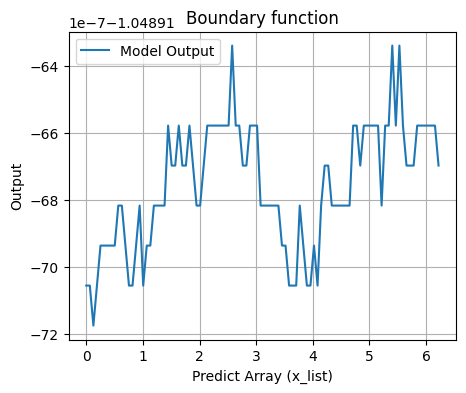

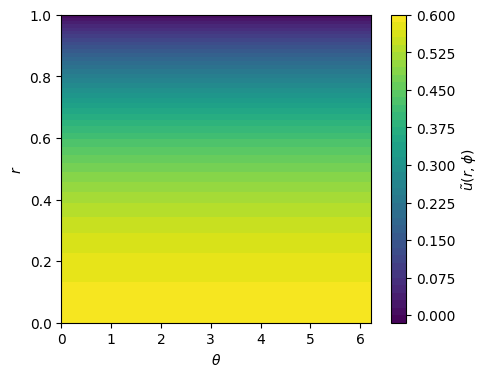

Computation time for 0: 2.1036267280578613 seconds
Iteration 2/12
Time taken: 55.62627124786377 seconds
1.266046


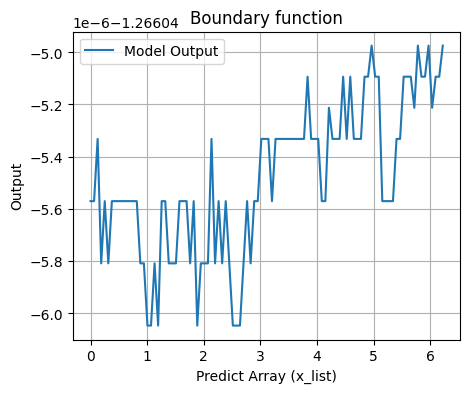

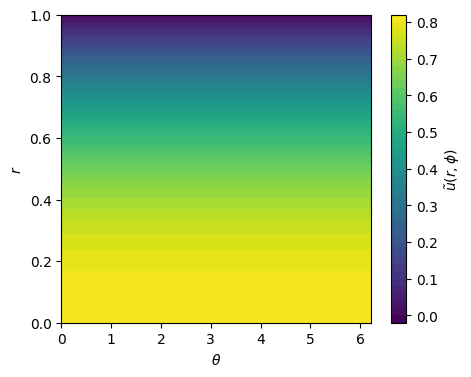

Computation time for 1: 2.1562340259552 seconds
Iteration 3/12
Time taken: 55.60158133506775 seconds
1.3473899


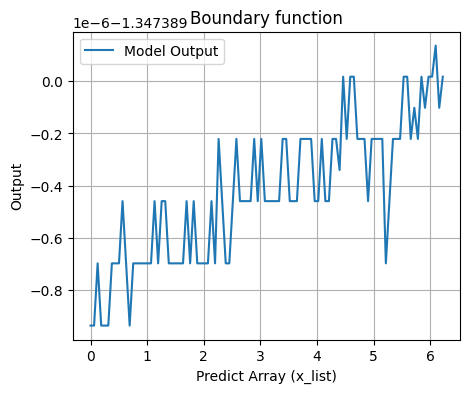

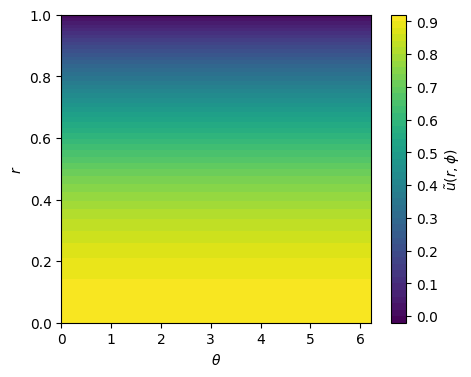

Computation time for 2: 2.1346874237060547 seconds
Iteration 4/12
Time taken: 56.703988552093506 seconds
1.3825777


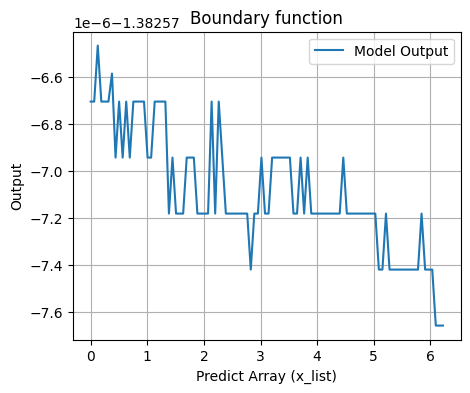

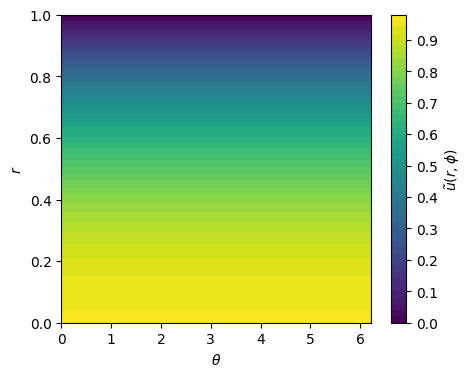

Computation time for 3: 2.129176616668701 seconds
Iteration 5/12
Time taken: 55.66811513900757 seconds
1.3986356


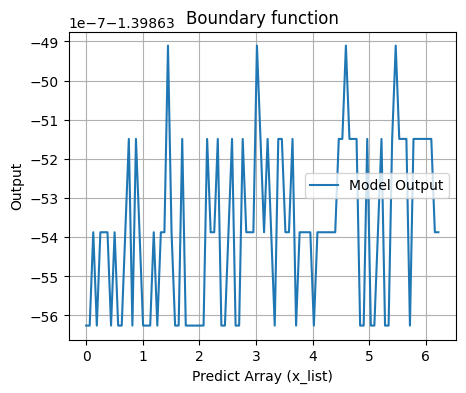

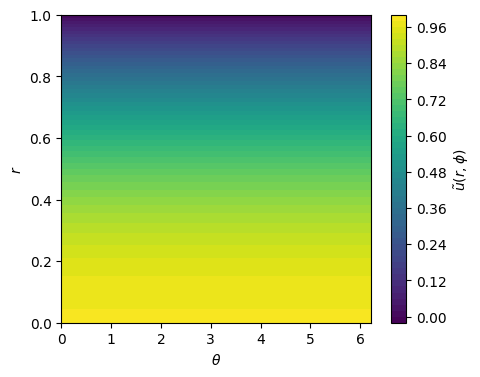

Computation time for 4: 2.147684097290039 seconds
Iteration 6/12
Time taken: 55.53436851501465 seconds
1.4061315


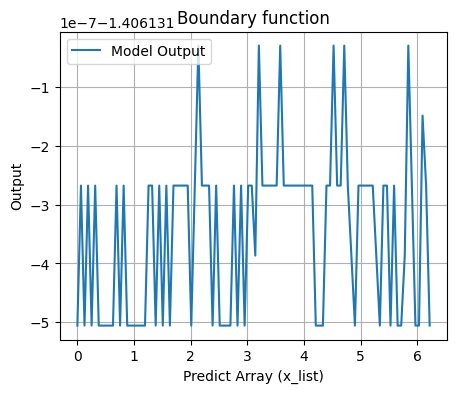

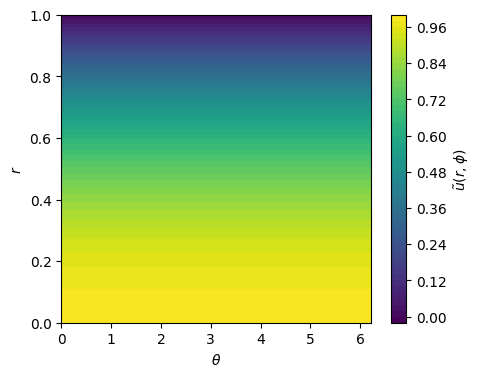

Computation time for 5: 2.1300313472747803 seconds
Iteration 7/12
Time taken: 55.570730686187744 seconds
1.4096682


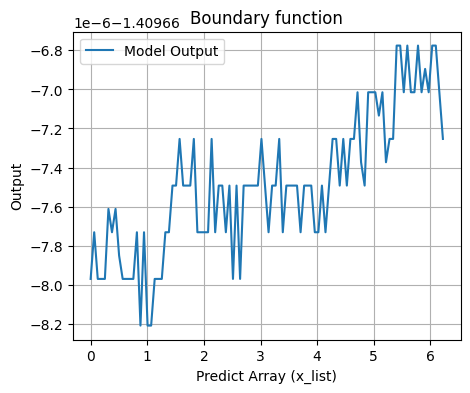

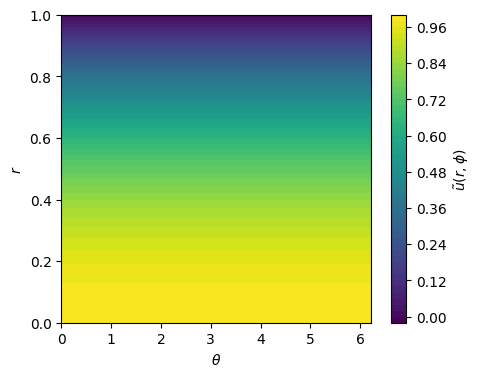

Computation time for 6: 2.1017355918884277 seconds
Iteration 8/12
Time taken: 55.47867131233215 seconds
1.4113436


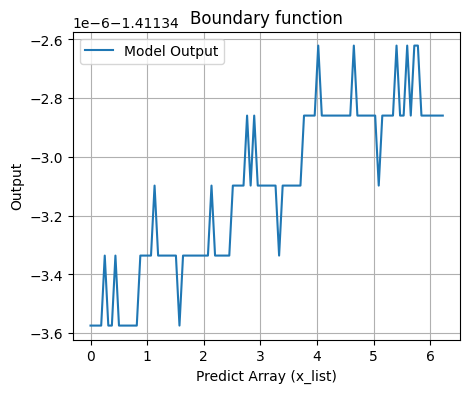

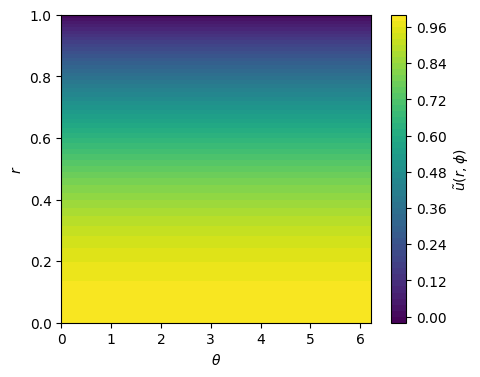

Computation time for 7: 2.097548007965088 seconds
Iteration 9/12
Time taken: 55.35833191871643 seconds
1.4121397


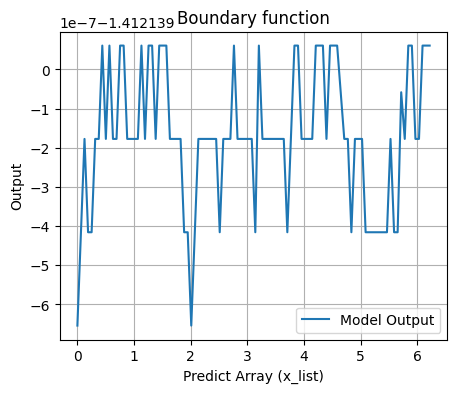

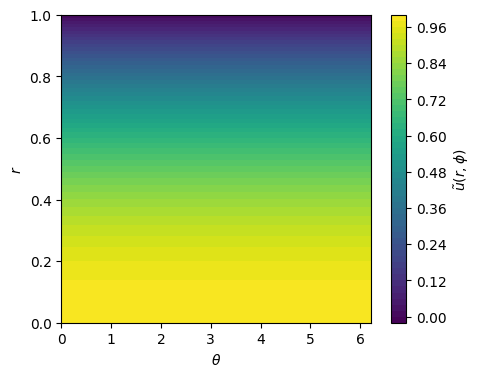

Computation time for 8: 2.119904041290283 seconds
Iteration 10/12
Time taken: 56.091397762298584 seconds
1.4125178


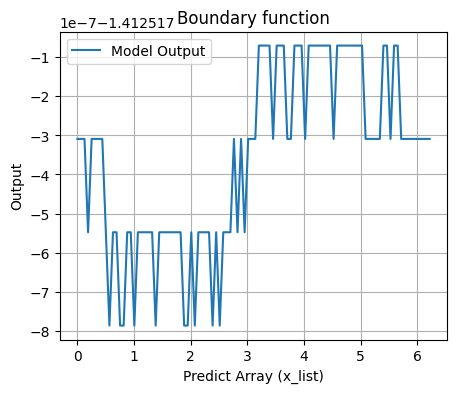

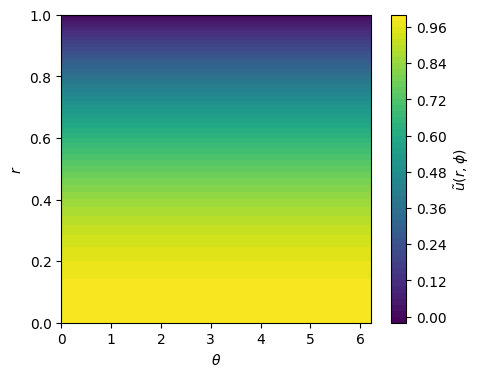

Computation time for 9: 2.1151134967803955 seconds
Iteration 11/12
Time taken: 55.7176148891449 seconds
1.4126985


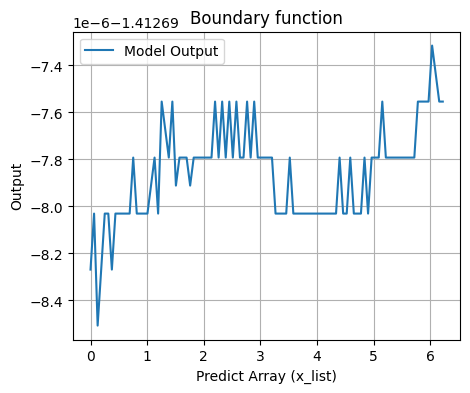

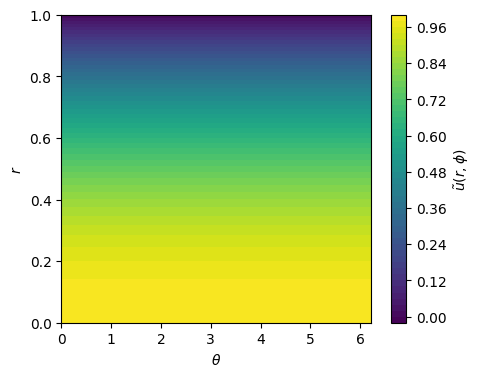

Computation time for 10: 2.101240634918213 seconds
Iteration 12/12
Time taken: 55.42039704322815 seconds
1.4127836


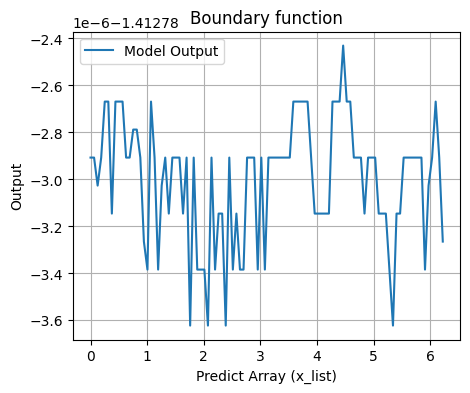

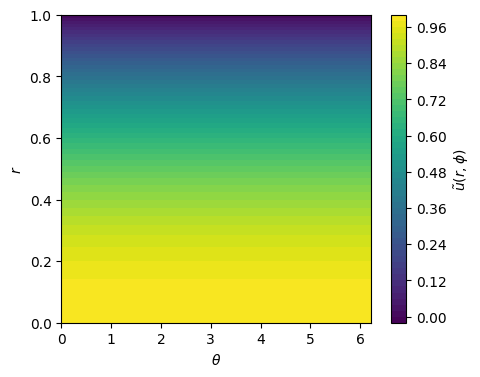

Computation time for 11: 2.1333718299865723 seconds


In [14]:
# Potential Fredholm Neural Network code for the semi-linear elliptic PDE
# In this Poisson example we only need to pass the integral fundamental*source for (r_o, theta_o) that will be added to the bias term

K = 100
phi_0 = 0.0
phi_n = 2.0 * np.pi
phi_steps = 100
phi = np.linspace(0.0, 2*np.pi, phi_steps, endpoint=False)
dphi = (2*np.pi) / phi_steps
# phi = np.arange(phi_0, phi_n, dphi)

phi_grid_dict = {}
for i in range(0, K + 1):
    phi_grid_dict[f'layer_{i}'] = phi

# Define predict array for FredholmNN
phi_grid = phi_grid_dict['layer_0']  # All layers share the same phi grid
phi_grid_torch = torch.tensor(phi_grid, dtype=torch.float32)

# Define r_out and theta_out ranges
r_out = np.linspace(0, 1, 100)
theta_out = phi_grid

# Initialize u_pred
u_pred = torch.zeros((len(r_out), len(theta_out)))
iterations = 12

# Compute integral of lambda*fund outside since it remains the same (upred does not effect it)
precomputed_integral_entire_domain_fund = parallel_integrate_meshgrid(r_out, theta_out)

for it in range(iterations):
  print(f"Iteration {it + 1}/{iterations}")
  start_time = time.time()

  # Compute integral of fund*source(u)
  precomputed_integral_entire_domain_source = compute_integral_fund_source(r_out = r_out,theta_out = theta_out, grid_step = dphi,
                                                                           fundamental_fn = fundamental_fn,source_non_linear = source_non_linear_torch,lambda_value = 1.0,
                                                                           r_space = r_out, theta_space = theta_out, u_pred = u_pred)

  # Take the value corresponding to r_out = 1 for Fredholm NN
  precomputed_integrals_p = precomputed_integral_entire_domain_source[-1,:].squeeze(-1).numpy()  # int fund*poisson
  #print(precomputed_integrals_p)

  # Convert results to tensor and map them to phi grid for quick lookup
  precomputed_integral_map = {value: integral for value, integral in zip(phi_grid, precomputed_integrals_p)}

  end_time = time.time()
  print(f"Time taken: {end_time - start_time} seconds")

  # Model parameters
  input_size = len(phi_grid)
  output_size = len(phi_grid_torch)
  km_constant = 0.3

  t_start = time.time()

  # Instantiate the Fredholm model
  fredholm_model = FredholmNeuralNetwork_semi_linear(
      phi_grid_dict, kernel, dphi, K, input_size, output_size, km_constant,
      func_fn, precomputed_integral_map)

  # Instantiate the LimitInformed model with the precomputed integral for r_out == 1
  limit_informed_model = PotentialFredholmNeuralNetwork_semi_linear(
      fredholm_model=fredholm_model,
      diff_potentials_fn=diff_potentials_limit,
      potential_boundary_fn=potential_boundary,
      precomputed_integral_entire_domain_fund=precomputed_integral_entire_domain_fund,
      precomputed_integral_entire_domain_source=precomputed_integral_entire_domain_source, plot_BIF = True)

  # Forward pass
  output = limit_informed_model(
      input=phi_grid_torch,
      r_out=r_out,
      theta_out=theta_out,
      phi_grid=phi_grid,
      grid_step=dphi)

  u_pred = output.squeeze(-1)

  # Extract data for visualization
  u_pred_current = output.detach().numpy()[:, :, 0]

  # Contour plot for visualization in (r, theta) space
  R_out, Theta_out = np.meshgrid(r_out, theta_out, indexing='ij')
  plt.figure(figsize=(5, 4))
  plt.contourf(Theta_out, R_out, u_pred_current, levels=50, cmap='viridis')
  cbar = plt.colorbar()
  # cbar.ax.tick_params(labelsize=18)
  cbar.set_label(r"$\tilde{u}(r,\phi)$")
  plt.xlabel(r"$\theta$")
  plt.ylabel(r"$r$")
  plt.tick_params(axis='both')
  plt.show()

  del precomputed_integral_entire_domain_source
  del precomputed_integrals_p
  del precomputed_integral_map
  del fredholm_model
  del limit_informed_model
  del output

  if torch.cuda.is_available():
    torch.cuda.empty_cache()

  # Force Python garbage collection
  gc.collect()

  t_end = time.time()
  comp_time = t_end - t_start
  print(f"Computation time for {it}: {comp_time} seconds")


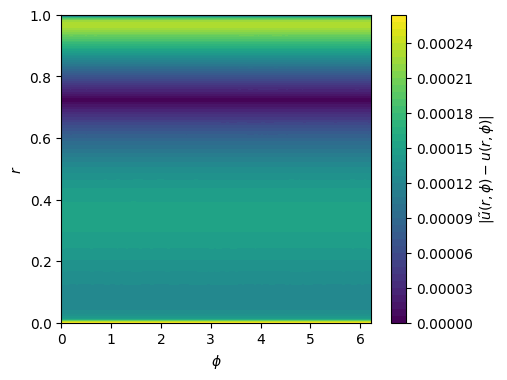

In [15]:
# Calculate and plot absolute error compared to the true solution

# True solution
def laplace_solution_cartesian(x, y):
    return 1 - x**2 - y**2

# Function to compute the Laplace solution in polar coordinates
def laplace_solution_polar(r, theta):
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return laplace_solution_cartesian(x, y)


u_true = laplace_solution_polar(R_out, Theta_out)
interior_error = np.abs(u_pred_current[:-1, :] - u_true[:-1, :])
boundary_error = np.abs(u_pred_current[-1, :] - u_true[-1, :])


# Create the contour plot for the absolute error
difference = np.abs(u_pred_current - laplace_solution_polar(R_out, Theta_out))
plt.figure(figsize=(5, 4))
plt.contourf(Theta_out, R_out, difference, levels=50, cmap='viridis')
cbar = plt.colorbar()
# cbar.ax.tick_params(labelsize=18)  # Increase font size for colorbar ticks
cbar.set_label(r"$|\tilde{u}(r,\phi) - u(r,\phi)|$")
plt.xlabel(r"$\phi$")
plt.ylabel(r"$r$")
plt.tick_params(axis='both')
plt.show()